In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.solvers.neuralDDE_with_adjoint as ndde
import src.bio_eqn_case.bio_eqn as bio

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDDE_args(ndde.arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, adj_data_size = 2,
                 model_dir = 'Bio_nDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2000., nt = 4000, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1., Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30, bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3
        elif bio_model_low_complex == 'NPZD': state_dim = 4
        elif bio_model_low_complex == 'NNPZD': state_dim = 5

        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_low_complex)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex

### Define the neural net architecture

In [5]:
class DDEFunc(tf.keras.Model):

    def __init__(self, rom_model, **kwargs):
        super(DDEFunc, self).__init__(**kwargs)

        self.rnn_layer = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(7, activation='tanh', use_bias=True, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), 
                                                                        recurrent_initializer='random_normal'))
        
        self.x1 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.rom_model = rom_model


    def call(self, y, t, d):
        input = []
        for i in np.flip(np.arange(d[0])): # d is a list and d[0] contains the number of steps, while d[1] contains the time-step value to skip
            input.append(tf.expand_dims(y(t - i*d[1]), axis=0))

        input = tf.concat(input, axis=0)
        input = tf.transpose(input, perm=[1, 0] + [i for i in range(2, input.shape.rank)])
        y_nn = input
        for i in range(len(self.layers)):
            y_nn = self.layers[i](y_nn)
            
#         sum_y_nn = tf.reduce_sum(y_nn, axis=-1)
#         y_nn = tf.stack([sum_y_nn, -sum_y_nn, tf.zeros_like(sum_y_nn)], axis=1)
        
        return y_nn + self.rom_model(y, t)

### Define a custom plotting function

In [6]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(6, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=14)
        ax_x1.set_xlabel('t', fontsize=14)
        ax_x1.set_ylabel('Concentration', fontsize=14)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], '-r', label = 'N (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 0], '-.r', label = 'N (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], '--r', label = 'N (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 1], '-g', label = 'P (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 1], '-.g', label = 'P (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 1], '--g', label = 'P (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 2], '-b', label = 'Z (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 2], '-.b', label = 'Z (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 2], '--b', label = 'Z (Learned)')

        ax_x1.set_xlim(self.t[0], self.t[-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

        plt.show() 

### Initial Conditions

In [7]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):

        if self.app.bio_model == 'NPZ':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5]
        elif self.app.bio_model == 'NPZD':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5, 0.]
        elif self.app.bio_model == 'NNPZD':
            x0 = [self.app.T_bio/2., self.app.T_bio/2. - 2*0.5, 0.5, 0.5, 0.]
        return tf.convert_to_tensor([x0], dtype=tf.float32)

### Initialize model related parameters

In [8]:
args = bio_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 500, learning_rate = 0.05, decay_rate = 0.97, test_freq = 1, plot_freq = 1,
                    d_max = 4., rnn_nmax = 3, rnn_dt = 1.5, model_dir = 'Bio_nDDE_testcase/model_dir_case30', restart = 1, val_percentage = 1.,
                    T = 20., nt = 400, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30., bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD')

### Make a copy of the current script

In [9]:
os.chdir(basedir)

checkpoint_dir = os.path.join(args.model_dir, "ckpt")
checkpoint_prefix = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

### Solve for the high complexity model

In [10]:
t = tf.linspace(0., args.T, args.nt) # Time array

x0_high_complex = initial_cond(args.bio_args_for_high_complex) # Initial conditions

x_high_complex = ddeinttf(bio.bio_eqn(args.bio_args_for_high_complex), x0_high_complex, t)

# Compute FOM for the validation time
dt = t[1] - t[0]
val_t_len =  args.val_percentage * (t[-1] - t[0])
n_val = np.ceil(np.abs(val_t_len/dt.numpy())).astype(int)
val_t = tf.linspace(t[-1], t[-1] + val_t_len, n_val)

val_x_high_complex = ddeinttf(bio.bio_eqn(args.bio_args_for_high_complex), ndde.create_interpolator(x_high_complex, t), val_t)

print('Higher complexity model done!')

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Higher complexity model done!


### Transform states of high complexity model to low complexity model

In [11]:
# Create modes for the training and validation period combined
true_x_low_complex = bio.convert_high_complex_to_low_complex_states(x_high_complex, args)

x0_low_complex = initial_cond(args)


Solve the low complexity model

In [12]:
x_low_complex = ddeinttf(bio.bio_eqn(args), x0_low_complex, t)

val_x_low_complex = ddeinttf(bio.bio_eqn(args), ndde.create_interpolator(x_low_complex, t), val_t)

#### Create validation set

In [13]:
val_obj = ndde.create_validation_set(x0_low_complex, t, args)

val_true_x_low_complex = bio.convert_high_complex_to_low_complex_states(val_x_high_complex, args)

## Main part starts here

### Make objects and define learning-rate schedule

In [14]:
func = DDEFunc(bio.bio_eqn(app = args))

### Quick test to see how the true coefficients looks like

In [15]:
func.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
pred_y = ddeinttf(func, x0_low_complex, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],))

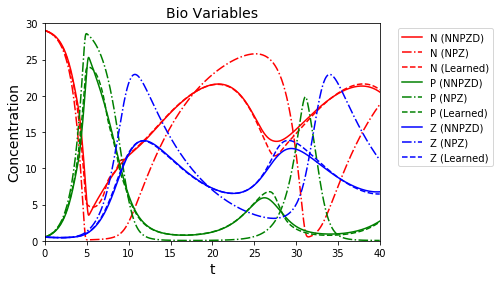

In [16]:
plot_obj = custom_plot(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_y)

### Print the network architecture

In [17]:
func.summary()

Model: "dde_func"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    multiple                  77        
_________________________________________________________________
dense (Dense)                multiple                  56        
_________________________________________________________________
dense_1 (Dense)              multiple                  24        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
